# Import needed libraries

In [17]:
import os
import time
import shutil
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import layers
from tensorflow.keras.metrics import categorical_crossentropy

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


# Read data

In [2]:
data_dir = 'C:/Users/pr503/Projects/skinn/hmnist_32_32_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,label
0,191,151,192,194,154,193,196,152,184,199,...,176,130,144,184,150,170,184,153,176,2
1,23,13,27,55,38,63,107,80,113,142,...,42,25,43,25,14,27,25,14,27,2
2,190,135,150,199,146,162,199,140,159,205,...,165,129,144,155,121,139,133,101,113,2
3,33,16,26,82,51,63,128,87,102,161,...,33,17,26,25,12,16,25,12,15,2
4,154,110,134,188,140,168,210,157,184,220,...,200,158,175,160,124,137,101,70,85,2


**Split data and labels**

In [3]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [4]:
data["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

We have imbalance in the data

**Handling imbalanced datasets**

In [5]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 32, 32, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 32, 32, 3)


In [6]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6], dtype=int64)

**Convert abbreviations to it's words**

In [7]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           3: ('df', 'dermatofibroma')}

# train_test_split

In [8]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 32, 32, 3)
(35201,)
(11734, 32, 32, 3)
(11734,)


**Convert labels to categorical types**

In [10]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Create Image Data Generation**

In [11]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

**Create ReduceLROnPlateau to learning rate reduction**

In [12]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 1
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [13]:
from keras.applications import DenseNet201
from keras import layers , Model

In [14]:
densenet = DenseNet201(weights='imagenet',include_top=False,input_shape=(32,32,3))

# Model Structure

In [21]:
x = densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 classes in HAM10000 dataset

model = Model(inputs=densenet.input, outputs=predictions)

for layer in densenet.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

**Training model**

In [22]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
276/276 [==============================] - 222s 747ms/step - loss: 1.1451 - accuracy: 0.6036 - val_loss: 1.1969 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 2/25
276/276 [==============================] - 208s 754ms/step - loss: 0.7249 - accuracy: 0.7499 - val_loss: 0.7408 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 3/25
276/276 [==============================] - 204s 738ms/step - loss: 0.5345 - accuracy: 0.8182 - val_loss: 0.4631 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 4/25
276/276 [==============================] - 206s 747ms/step - loss: 0.4124 - accuracy: 0.8617 - val_loss: 0.3999 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 5/25
276/276 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8920
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
276/276 [==============================] - 195s 708ms/step - loss: 0.3352 - accuracy: 0.8920 - val_loss: 0.7100 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 6/25
276/276 [========================

**Show training history**

In [23]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

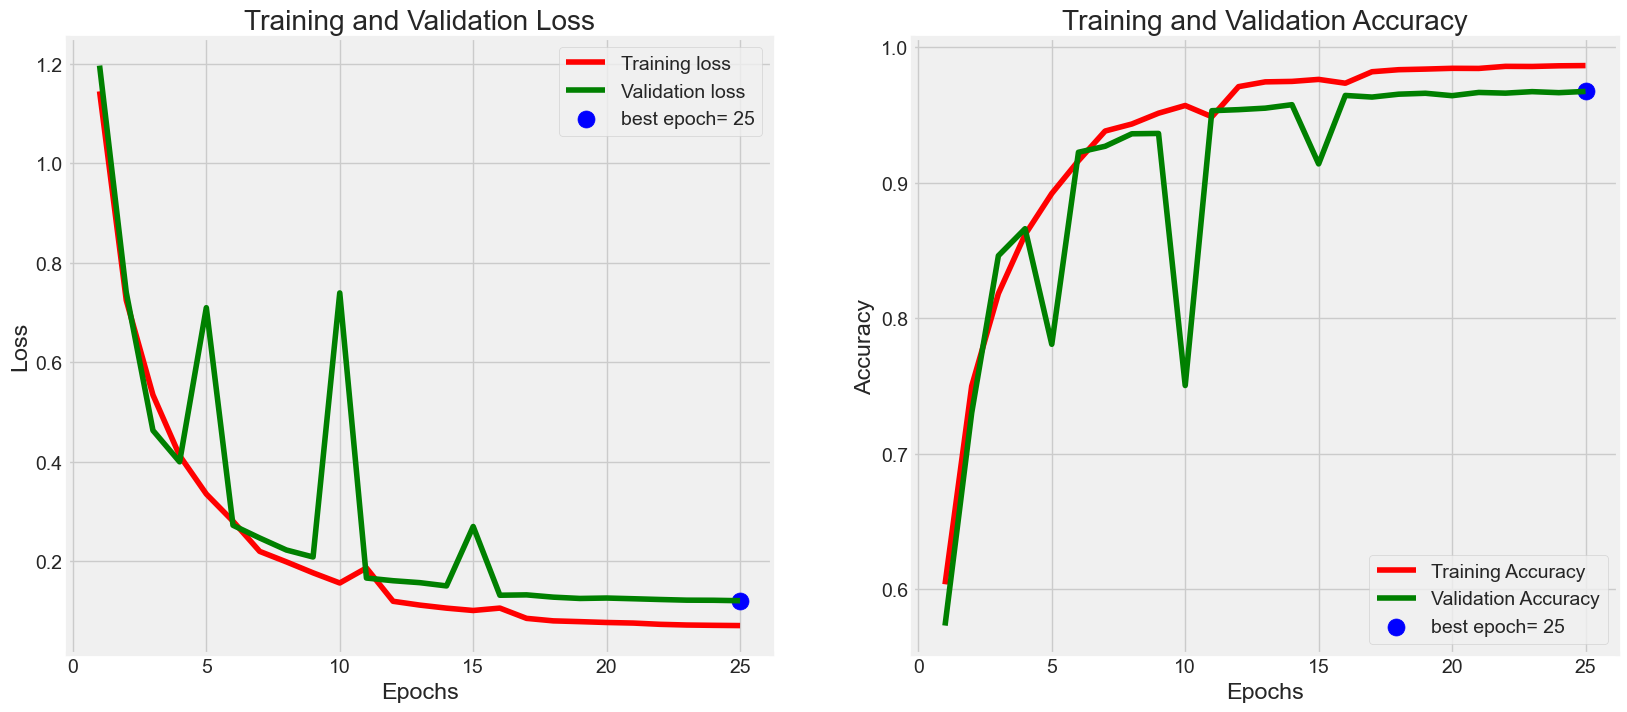

In [24]:
plot_training(history)

# Model Evaluation

In [25]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 84s 228ms/step - loss: 0.1206 - accuracy: 0.9674
Train Loss:  0.0699114054441452
Train Accuracy:  0.9870458245277405
--------------------
Test Loss:  0.1205868273973465
Test Accuracy:  0.9673597812652588


In [26]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 80s 204ms/step


**Create classes labels**

In [27]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 0, 5, 3]


**Confussion Matrix**

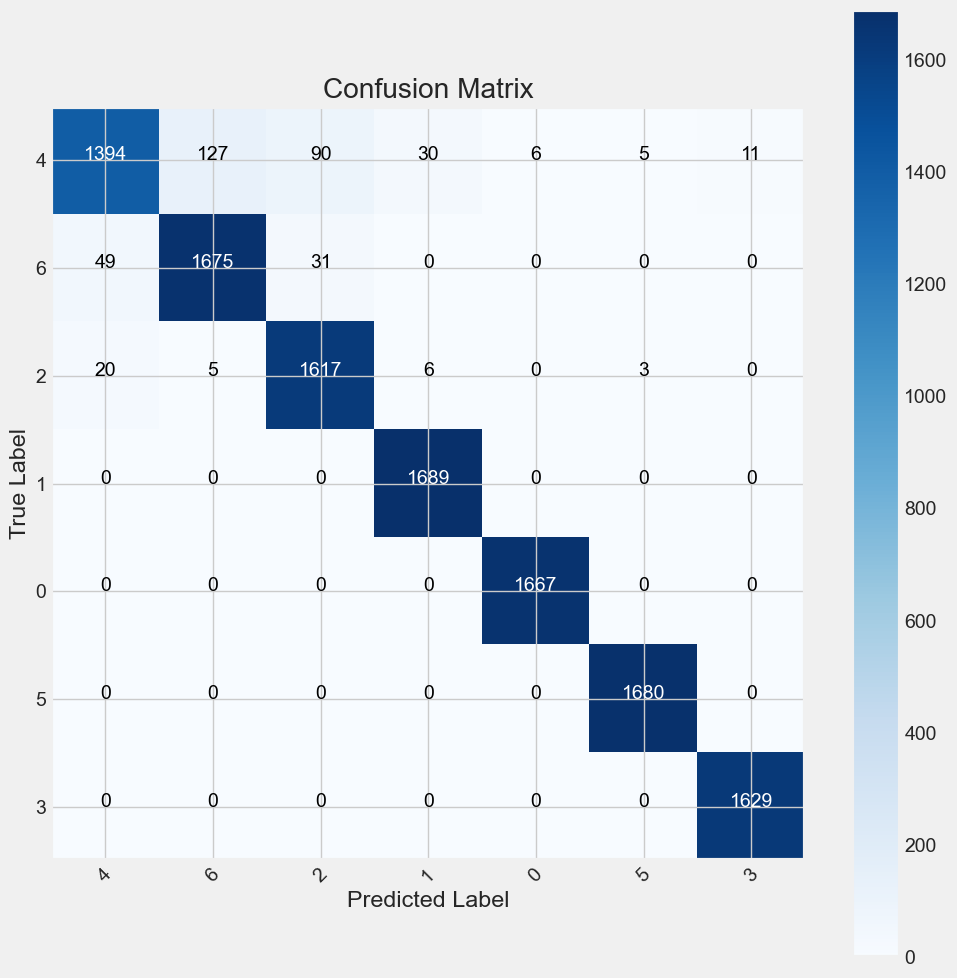

In [28]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

**Save model**

In [29]:
#Save the model
model.save('Skin_Cancer_DenseNet201.h5')